In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from scipy.stats import shapiro, kstest
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Feature Engineering

In [2]:
# Read in repeats file and column names file

df = pd.read_csv('/rds/projects/v/varnaic-schic-ml/Data/RepeatMasker/rmsk.txt', delimiter='\t')

# Step 1: Read the single row from the CSV file as a list of column names
column_names = pd.read_csv('columns_rmsk.csv', header=None).iloc[0].tolist()

# Step 2: Read the data from the TXT file without headers
data = pd.read_csv('/rds/projects/v/varnaic-schic-ml/Data/RepeatMasker/rmsk.txt', delimiter='\t', header=None)

# Step 3: Assign the column names to the DataFrame
data.columns = column_names

# Display the DataFrame
#print(data)

In [3]:
# Calculate densities of repeats with chromosome lengths

# Load chromosome lengths CSV file
chrom_lengths = pd.read_csv('chr_len.csv', header=None, names=['Chromosome', 'Length'])

# Strip any extra whitespace from chromosome names
chrom_lengths['Chromosome'] = chrom_lengths['Chromosome'].str.strip()

# Ensure chromosomes are sorted lexicographically (chr1, chr2, ..., chr19)
chromosomes_sorted = sorted(chrom_lengths['Chromosome'], key=lambda x: int(x[3:]))

# Step 1: Filter to include only chr1 to chr19
chromosomes_to_keep = [f'chr{i}' for i in range(1, 20)]
filtered_data = data[data['genoName'].isin(chromosomes_to_keep)]

# Step 2: Remove repeat classes with '?' at the end
filtered_data = filtered_data[~filtered_data['repClass'].str.endswith('?')]

# Step 3: Group by chromosome (genoName) and repeat class (repClass) and count the number of entries
count_df = filtered_data.groupby(['genoName', 'repClass']).size().unstack(fill_value=0)

# Step 4: Rename the index to show that it represents chromosomes
count_df.index.name = 'Chromosome'
count_df.columns.name = 'RepeatClass'

# Step 5: Sort chromosomes in natural order
count_df = count_df.reindex(chromosomes_sorted)

# Step 6: Merge count_df with chrom_lengths
merged_df = count_df.merge(chrom_lengths, on='Chromosome', how='left')

# Step 7: Calculate the density by dividing each repeat count by the corresponding chromosome length
for column in count_df.columns:
    merged_df[column] = merged_df[column] / merged_df['Length']

# Step 8: Drop the Length column after calculation if no longer needed
density_df = merged_df.drop(columns=['Length'])

# Print the resulting density DataFrame
#print(density_df)

In [4]:
# Use density_df to create interaction matrix

import pandas as pd

# Set 'Chromosome' as the index so that it matches the structure of 'count_df'
density_df.set_index('Chromosome', inplace=True)

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Interaction'] + list(density_df.columns))

# Define chromosome numbers
chromosomes = list(range(1, 20))  # Chromosomes 1 through 19

# Create an empty list to store all interactions in the desired order
all_interactions = []

# Generate interactions for each maternal chromosome
for i in range(len(chromosomes)):
    # Maternal-Maternal interactions for a single chromosome
    for j in range(i + 1, len(chromosomes)):
        all_interactions.append(f"{chromosomes[i]}m-{chromosomes[j]}m")
    
    # Maternal-Paternal interactions for the same chromosome
    for j in range(len(chromosomes)):
        all_interactions.append(f"{chromosomes[i]}m-{chromosomes[j]}p")

# Generate all paternal-paternal interactions in order
for i in range(len(chromosomes)):
    for j in range(i + 1, len(chromosomes)):
        all_interactions.append(f"{chromosomes[i]}p-{chromosomes[j]}p")

# Loop through all interactions and populate the result_df
for interaction_name in all_interactions:
    chr1, chr2 = interaction_name.split('-')
    chr1_base = chr1[:-1]
    chr2_base = chr2[:-1]
    
    # Retrieve the interaction data from density_df
    interaction_data = density_df.loc[f'chr{chr1_base}'] * density_df.loc[f'chr{chr2_base}']
    
    # Add the interaction data to the DataFrame
    result_df = result_df.append(pd.Series([interaction_name] + interaction_data.tolist(), index=result_df.columns), ignore_index=True)

# Now 'result_df' contains the desired interaction data based on 'density_df'
#print(result_df)

In [5]:
# Take log

# Convert all columns (except 'Interaction') to numeric, if possible
result_df_numeric = result_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Apply the logarithm to the numeric data
log_result_df = result_df.copy()
log_result_df.iloc[:, 1:] = np.log(result_df_numeric)

In [6]:
# Create individual vectors for each column

for column in log_result_df.columns[1:]:  # Skip the 'Interaction' column
    globals()[f"{column}_vec"] = log_result_df[column].values

In [7]:
#DNA_vec
#LINE_vec
#LTR_vec
#Low_complexity_vec

In [8]:
# Add vectors to X matrix

# Step 1: Read in X_matrix data
X = pd.read_csv('X_matrix.csv')
#X
# Rename the column in the X matrix
X.rename(columns={'Chr_len_log': 'Chr_len'}, inplace=True)


#Step 2: Add repeat vectors as features
# Loop through each column in result_df, skipping the 'Interaction' column
for column in log_result_df.columns[1:]:  # Skip the 'Interaction' column
    # Add each vector as a new column in the X DataFrame
    X[column] = log_result_df[column].values
    
#X

In [9]:
# Save as CSV
#X.to_csv('X_repeats_densities.csv', index=False)

In [10]:
# Add y 

# Read in ESC matrix
ESC = pd.read_csv('ESC_new.csv', index_col=0)

# Define function for matrix to vector without indices
def matrix_to_values(matrix):
    values = []
    rows = matrix.shape[0]  # Number of rows
    cols = matrix.shape[1]  # Number of columns

    for i in range(rows):
        for j in range(i + 1, cols):  # Ensure j > i to avoid duplicates
            # Append only the value to the values list
            values.append(matrix.iloc[i, j])

    return values

# Use function on all matrices
v1 = matrix_to_values(ESC)

y = np.log(v1)

In [11]:
# Convert non-numeric columns to numeric, if applicable
X = X.apply(pd.to_numeric, errors='coerce')

### Correlation Analysis

In [12]:
# Check correlation

correlations = X.corr()
#print(correlations)

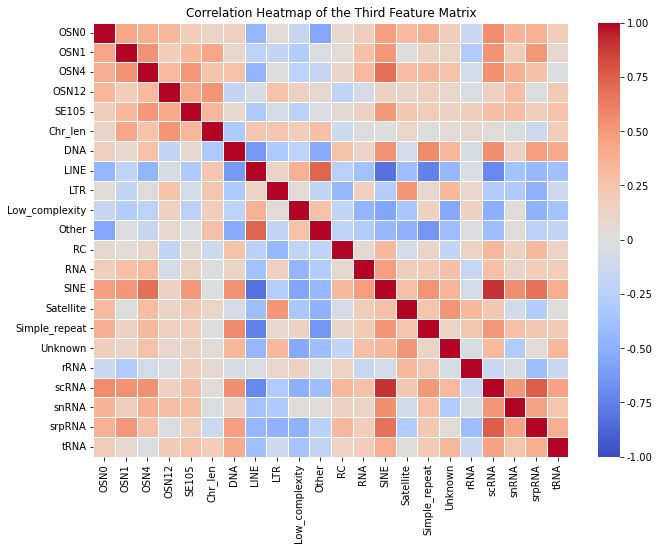

In [13]:
# Plot correlation heatmap

plt.figure(figsize=(10, 8))  # Set the size of the heatmap

# Create the heatmap with the desired settings
heatmap = sns.heatmap(correlations, annot=False, cmap='coolwarm', linewidths=0.5, center=0, vmin=-1, vmax=1)

# Create a custom colorbar with the desired ticks
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
colorbar.set_ticklabels(['-1.00', '-0.75', '-0.50', '-0.25', '0', '0.25', '0.50', '0.75', '1.00'])

# Add title and adjust layout
plt.title('Correlation Heatmap of the Third Feature Matrix')
plt.tight_layout(pad=2.0)  # Adjust layout

# Save the plot with tight bounding box and higher resolution
#plt.savefig('third_corr_hm.jpg', dpi=300, bbox_inches='tight')
plt.show()


### Regression Analysis

In [14]:
# Use Random Forest with X and y

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate metrics for training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print metrics
print(f'Training Mean Squared Error: {train_mse:.2f}')
print(f'Training R-squared: {train_r2:.2f}')
print(f'Test Mean Squared Error: {test_mse:.2f}')
print(f'Test R-squared: {test_r2:.2f}')

# Feature importance
feature_importances = model.feature_importances_
features = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print('Feature Importances:')
print(importance_df)

Training Mean Squared Error: 0.00
Training R-squared: 0.95
Test Mean Squared Error: 0.01
Test R-squared: 0.68
Feature Importances:
           Feature  Importance
5          Chr_len    0.299347
3            OSN12    0.176438
4            SE105    0.104726
2             OSN4    0.098487
0             OSN0    0.058564
1             OSN1    0.054386
15   Simple_repeat    0.020157
11              RC    0.016069
19           snRNA    0.015217
21            tRNA    0.015175
14       Satellite    0.014246
18           scRNA    0.014063
10           Other    0.013427
9   Low_complexity    0.012727
17            rRNA    0.012208
12             RNA    0.011954
6              DNA    0.011737
13            SINE    0.011203
8              LTR    0.010955
16         Unknown    0.010624
20          srpRNA    0.009246
7             LINE    0.009041


### Feature Importance

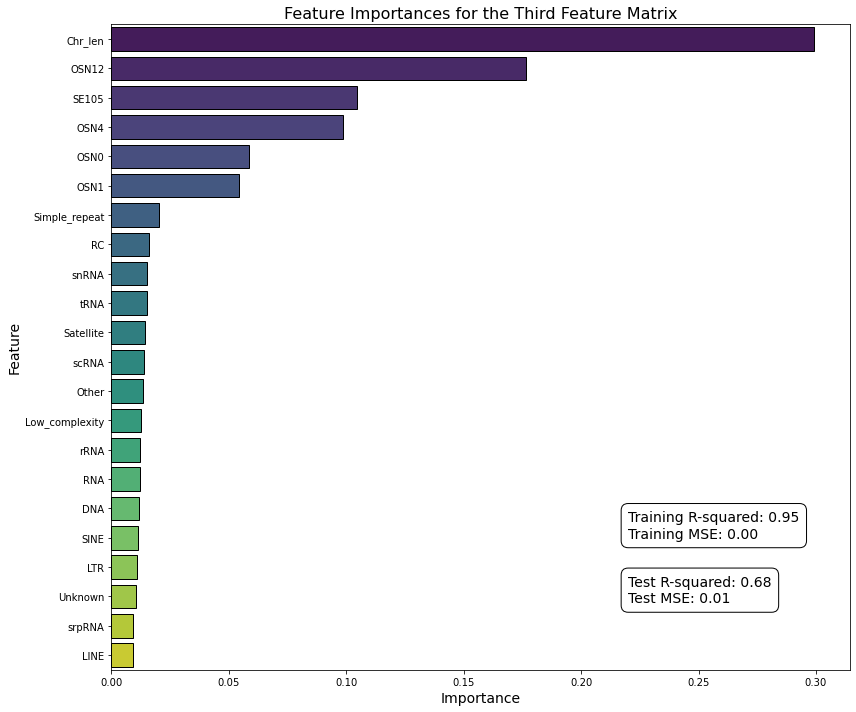

In [ ]:
# Plot feature importances 
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', edgecolor='black')

plt.title('Feature Importances for the Third Feature Matrix', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Add text boxes 
plt.text(0.7, 0.2, f'Training R-squared: {train_r2:.2f}\nTraining MSE: {train_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(0.7, 0.1, f'Test R-squared: {test_r2:.2f}\nTest MSE: {test_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout()
#plt.savefig('Third_matrix_importance.jpg', dpi=300, bbox_inches='tight')
plt.show()


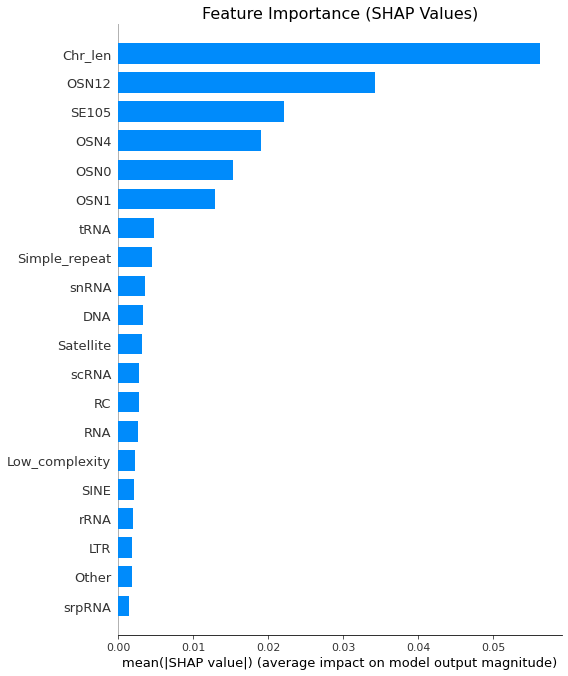

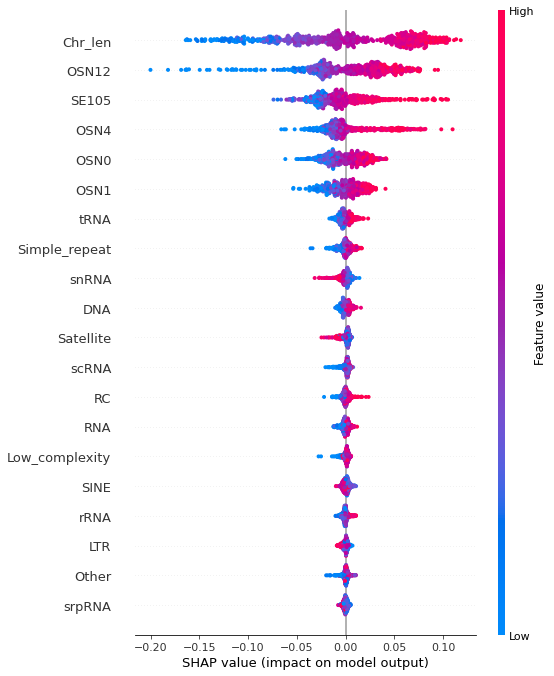

In [ ]:
import shap

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Plot the summary of SHAP values
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title('Feature Importance (SHAP Values)', fontsize=16)
plt.tight_layout()

# Save the plot as a JPEG file
#plt.savefig('SHAP.jpg', dpi=300)
plt.show()

# Create the SHAP summary plot
shap.summary_plot(shap_values, X, show=False)

# Save the plot
#plt.savefig('third_shap_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.show() 

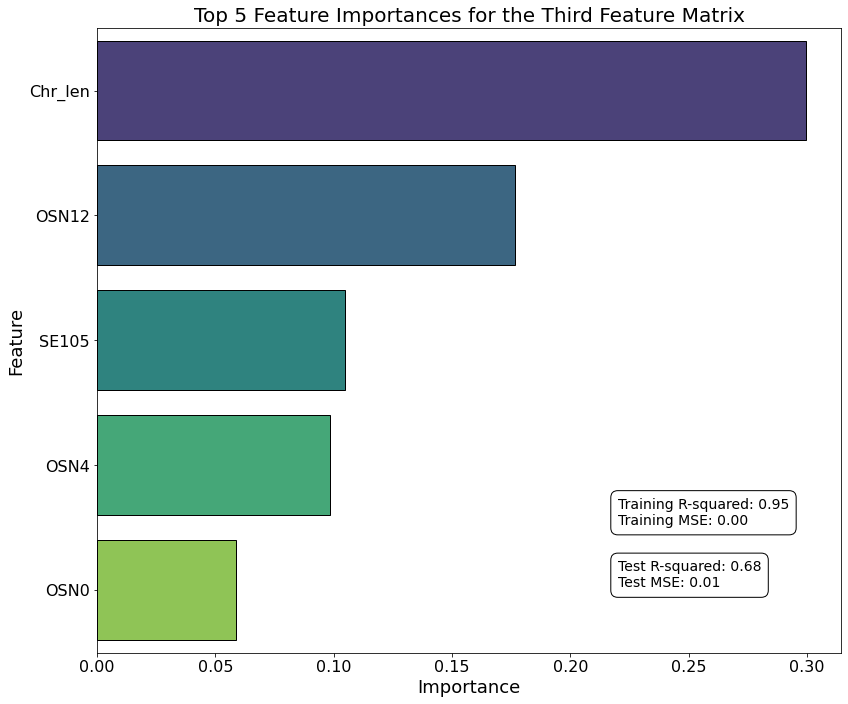

In [19]:
# Sort importance_df to get the top 5 most important features
top_5_importance_df = importance_df.sort_values(by='Importance', ascending=False).head(5)

# Plot the top 5 feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_5_importance_df, palette='viridis', edgecolor='black')

plt.title('Top 5 Feature Importances for the Third Feature Matrix', fontsize=20)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)

# Increase font size of the feature names on the y-axis
plt.yticks(fontsize=16)
# Increase font size of the importance values on the x-axis
plt.xticks(fontsize=16)

# Add text boxes with evaluation metrics at the bottom of the plot
plt.text(0.7, 0.2, f'Training R-squared: {train_r2:.2f}\nTraining MSE: {train_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.text(0.7, 0.1, f'Test R-squared: {test_r2:.2f}\nTest MSE: {test_mse:.2f}',
         transform=plt.gca().transAxes, fontsize=14, verticalalignment='bottom',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.tight_layout()
plt.savefig('Top_5_third_matrix_importance.jpg', dpi=300, bbox_inches='tight')
plt.show()

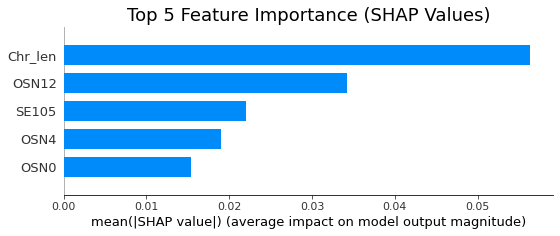

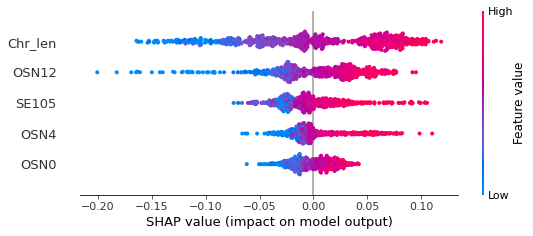

In [18]:
# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Calculate mean absolute SHAP values for each feature to find the top 5
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_5_indices = np.argsort(mean_abs_shap)[-5:]  # Get indices of top 5 features

# Filter the SHAP values and the corresponding feature names for the top 5
shap_values_top_5 = shap_values[:, top_5_indices]
X_top_5 = X.iloc[:, top_5_indices]

# Increase font sizes globally
plt.rcParams.update({'font.size': 14})

# Plot the summary of SHAP values for the top 5 features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_top_5, X_top_5, plot_type="bar", show=False)
plt.title('Top 5 Feature Importance (SHAP Values)', fontsize=18)
plt.tight_layout()

# Save the plot as a JPEG file with higher resolution (dpi)
#plt.savefig('SHAP_top_5.jpg', dpi=300)
plt.show()

# Create the SHAP summary plot for the top 5 features
shap.summary_plot(shap_values_top_5, X_top_5, show=False)

# Save the plot
plt.savefig('third_top_5_shap_summary_plot.jpg', dpi=300, bbox_inches='tight')
plt.show() 